## Methodology per Blair Russell

We may want to rethink the denominator of our equation for housing cost burden.

"Right now it’s all housing units with a cost burden computed. 

Alternatively, you could use low-income households (with cost burden computed) as the denominator, which would be a measure of relative cost burden just for low-income households. 

Both approaches are appropriate, but they tell a different story. You can imagine an area with few low-income households but a vast majority of them being cost burdened. In your calculation, you’d get a small percentage. 

In the alternative approach, it’s a large percentage. Just something to think about. It depends on the story you want to tell."


#### Packages

In [1]:
import math
import numpy as np
import os
import requests
import sys
import zipfile
import shutil
from pathlib import Path
import pandas as pd

# Table of Contents

Comparisons
*  [Implementation by Lucas](#lucas)
*  [Implementation by Saran](#saran)
*  [Side-by-side Comparison](#comparison)

The relevant denominator variables - all with line type of subtotal - in table 8 of the CHAS dataset are the following (CHAS data dictionary available [here](https://www.huduser.gov/portal/datasets/cp/CHAS-data-dictionary-14-18.xlsx)):

|   Name  |                          Label                      |
|---------|-----------------------------------------------------|
|T1_est3  |      Owner occupied less or equal to 30% of HAMFI   |                                                    | 
|T8_est16 |            Owner occupied greater than 30% of HAMFI cost burden less than 50%           |
|T8_est29 |Owner occupied greater than 50% but less than or equal to 80% of HAMFI	cost burden |
|T8_est69 |Renter occupied less than or equal to 30% of HAMFI|
|T8_est82 |           Renter occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est95 |Renter occupied	greater than 50% but less than or equal to 80% of HAMFI|
 

# ETL - one needs to only run this cell block once to replicate the subsequent notebooks in this draft PR

##### Once run, Table 8 will be in the notebook's current working directory

In [6]:
# Copy and adapt certain sections of code from data_pipeline.utils 

def download_hud_dataset():
    DOWNLOAD_FILENAME = "HUD_ZIPPED.csv"
    HOUSING_FTP_URL = "https://www.huduser.gov/portal/datasets/cp/2014thru2018-140-csv.zip"    
    response = requests.get(HOUSING_FTP_URL, verify=True)
    if response.status_code == 200:
        file_contents = response.content
    else:
        sys.exit(
            f"HTTP response {response.status_code} from url {file_url}. Info: {response.content}"
        )

    # Write the contents to disk.
    file = open(DOWNLOAD_FILENAME, "wb")
    file.write(file_contents)
    file.close()
    
def extract_zipped_download(zip_file_path, unzipped_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(unzipped_path)
    # cleanup temporary file
    os.remove(zip_file_path)
    
def up_one_directory(path):
    try:
        # from Python 3.6
        parent_dir = Path(path).parents[1]
        # for Python 3.4/3.5, use str to convert the path to string
        # parent_dir = str(Path(path).parents[1])
        shutil.move(path, parent_dir)
    except IndexError:
        # no upper directory
        pass

CURRENT_DIRECTORY = os.getcwd()
download_hud_dataset()
extract_zipped_download(CURRENT_DIRECTORY + "/HUD_ZIPPED.csv", CURRENT_DIRECTORY)  
up_one_directory(CURRENT_DIRECTORY + "/140/Table8.csv")
shutil.rmtree("./140/")

### Implementation by Lucas <a id='lucas'></a>

In [7]:
# Read in the data from https://www.huduser.gov/portal/datasets/cp.html
housing = pd.read_csv("Table8.csv", 
                      encoding="latin-1",  
                      dtype = {'Tract_ID': object, 'st': object, 'geoid': object})

# Remove data for states that aren't included in the census (e.g. American Samoa, Guam, etc.):
housing.drop(housing.loc[housing['st'] == '72'].index, inplace = True)

# Rename columns
housing = housing.rename(columns = {'geoid' :'FIPS_tract_id',
                                    'st' : 'state'
                                   })

# Owner occupied numerator fields
OWNER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est7",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est10",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est20",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est23",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est33",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est36",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
OWNER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est13",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est26",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est39",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est52",
    #   Subtotal
    #   Owner occupied
    #   greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est65",
    #   Subtotal
    #   Owner occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

OWNER_OCCUPIED_POPULATION_FIELD = "T8_est2"
#   Subtotal
#   Owner occupied
#   All
#   All
#   All

OWNER_OCCUPIED_POPULATION_HAMFI_FIELD = "T8_est3"
#   Subtotal
#   Owner occupied 
#   All
#   All
#   All

# Renter occupied numerator fields
RENTER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est73",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est76",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est86",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est89",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est99",
    #   Subtotal
    #   Renter occupied	greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est102",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
RENTER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est79",
    #   Subtotal
    #   Renter occupied	less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est92",
    #   Subtotal
    #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est105",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est118",
    #   Subtotal
    #   Renter occupied	greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est131",
    #   Subtotal
    #   Renter occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

# T8_est68	SubtotalRenter occupied	All	All	All
RENTER_OCCUPIED_POPULATION_FIELD = "T8_est68"

In [8]:
# Original computation:
# (
#     # of Owner Occupied Units Meeting Criteria
#     + # of Renter Occupied Units Meeting Criteria
# )
# divided by
# (
#     Total # of Owner Occupied Units
#     + Total # of Renter Occupied Units
#     - # of Owner Occupied Units with HAMFI Not Computed
#     - # of Renter Occupied Units with HAMFI Not Computed
# )

housing["numerator_pre"] = housing[
    OWNER_OCCUPIED_NUMERATOR_FIELDS
].sum(axis=1) + housing[RENTER_OCCUPIED_NUMERATOR_FIELDS].sum(axis=1)



housing["denominator_pre"] = (
    housing[OWNER_OCCUPIED_POPULATION_FIELD]
    + housing[RENTER_OCCUPIED_POPULATION_FIELD]
    - housing[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
    - housing[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

### Implementation by Saran <a id='saran'></a>

In [9]:
OWNER_REVISED_DENOMINATOR_FIELDS =   [
            # Column Name
            #   Line_Type
            #   Tenure
            #   Household income
            #   Cost burden
            #   Facilities
            "T8_est3",
            #   Subtotal
            #   Renter occupied	less than or equal to 30% of HAMFI
            #   All
            "T8_est16",
            #   Subtotal
            #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
            #   All
            "T8_est29",
            #   Subtotal
            #   Renter occupied
            #   greater than 50% but less than or equal to 80% of HAMFI
            #   All
        ]

RENTAL_REVISED_DENOMINATOR_FIELDS =   [
            # Column Name
            #   Line_Type
            #   Tenure
            #   Household income
            #   Cost burden
            #   Facilities
            "T8_est69",
            #   Subtotal
            #   Renter occupied	less than or equal to 30% of HAMFI
            #   All
            "T8_est82",
            #   Subtotal
            #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
            #   All
            "T8_est95",
            #   Subtotal
            #   Renter occupied
            #   greater than 50% but less than or equal to 80% of HAMFI
            #   All
        ]

# New computation:
# (
#     # of Owner Occupied Units Meeting Criteria
#     + # of Renter Occupied Units Meeting Criteria
# )
# divided by
# (
#     Total # of Owner Occupied Units that meet criterion for poverty
#     + Total # of Renter Occupied Units that meet criterion for poverty
#     - # of Owner Occupied Units with HAMFI Not Computed
#     - # of Renter Occupied Units with HAMFI Not Computed
# )

housing['denominator_post'] = housing[
    RENTAL_REVISED_DENOMINATOR_FIELDS
].sum(axis = 1) + housing[OWNER_REVISED_DENOMINATOR_FIELDS].sum(axis = 1) - (
    - housing[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
    - housing[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

In [10]:
housing.iloc[:, -3:].head()

,numerator_pre,denominator_pre,denominator_post
0,174,765,295
1,177,720,350
2,279,1291,559
3,274,1635,525
4,885,4135,1090


#### Concatenate GeoIDs with Derived Columns

In [11]:
housing_df = pd.concat([housing.iloc[:, 2: 7], housing.iloc[:, -3:]], axis = 1)

In [12]:
housing_df["ratio_pre"] = np.round(
    housing_df['numerator_pre'] / housing_df['denominator_pre'], 2)

In [13]:
housing_df["ratio_post"] = np.round(
    housing_df['numerator_pre'] / housing_df['denominator_post'], 2)

### Comparison <a id='comparison'></a>

In [14]:
housing_df.head()

,FIPS_tract_id,name,state,cnty,tract,numerator_pre,denominator_pre,denominator_post,ratio_pre,ratio_post
0,14000US01001020100,"Census Tract 201, Autauga County, Alabama",01,1,20100,174,765,295,0.23,0.59
1,14000US01001020200,"Census Tract 202, Autauga County, Alabama",01,1,20200,177,720,350,0.25,0.51
2,14000US01001020300,"Census Tract 203, Autauga County, Alabama",01,1,20300,279,1291,559,0.22,0.50
3,14000US01001020400,"Census Tract 204, Autauga County, Alabama",01,1,20400,274,1635,525,0.17,0.52
4,14000US01001020500,"Census Tract 205, Autauga County, Alabama",01,1,20500,885,4135,1090,0.21,0.81


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<AxesSubplot:title={'center':'Relative Housing Burden for Low-Income Hosuing Only'}, xlabel='Ratio', ylabel='Frequency'>

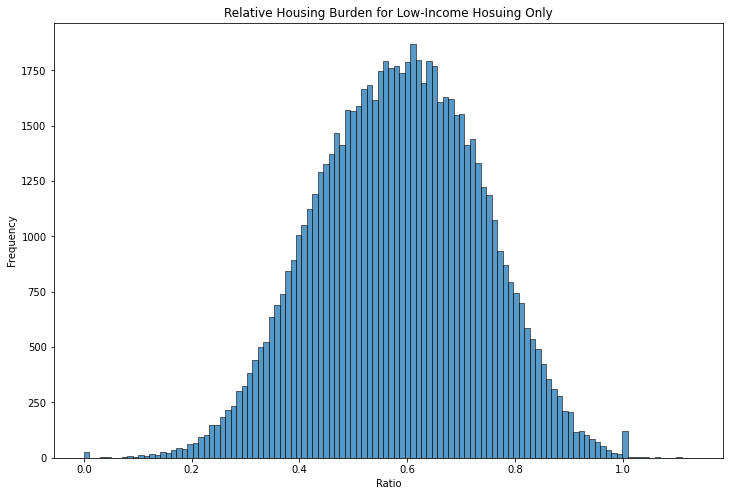

In [16]:
plt.figure(figsize=(12, 8))
plt.title('Relative Housing Burden for Low-Income Hosuing Only')
# Set x-axis label
plt.xlabel('Ratio')
# Set y-axis label
plt.ylabel('Frequency')

sns.histplot(housing_df["ratio_post"])

In [17]:
housing_df[housing_df["ratio_post"] > 1][['name', "FIPS_tract_id",  'ratio_post']]

,name,FIPS_tract_id,ratio_post
4203,"Census Tract 3923, Contra Costa County, Califo...",14000US06013392300,1.01
4617,"Census Tract 38.06, Kern County, California",14000US06029003806,1.03
5262,"Census Tract 2060.20, Los Angeles County, Cali...",14000US06037206020,1.07
5565,"Census Tract 2626.01, Los Angeles County, Cali...",14000US06037262601,1.06
12908,"Census Tract 303, Fairfield County, Connecticut",14000US09001030300,1.04
14086,"Census Tract 102, District of Columbia, Distri...",14000US11001010200,1.02
17668,"Census Tract 273.23, Pinellas County, Florida",14000US12103027323,1.02
18102,"Census Tract 208.10, Seminole County, Florida",14000US12117020810,1.03
19796,"Census Tract 101.02, Liberty County, Georgia",14000US13179010102,1.06
21166,"Census Tract 507, Cook County, Illinois",14000US17031050700,1.03
